In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [74]:
def get_data():
    fake_dataset = pd.read_csv('Fake.csv')
    real_dataset = pd.read_csv('True.csv')
    return fake_dataset, real_dataset


In [75]:
fake_dataset, real_dataset = get_data()


#DATA PREPROCESSING

In [76]:
fake_dataset.head()
#fake_dataset.info()
#fake_dataset.shape

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [77]:
real_dataset.head()
#real_dataset.shape

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [78]:
real_dataset['text_length'] = real_dataset['text'].apply(lambda x: len(x.split()))
fake_dataset['text_length'] = fake_dataset['text'].apply(lambda x: len(x.split()))

In [79]:
print(real_dataset['text_length'].mean())
print(fake_dataset['text_length'].mean())

385.6400989867862
423.1979046888974


In [80]:
fake_dataset['label'] = 1
real_dataset['label'] = 0

In [81]:
df = pd.concat([fake_dataset, real_dataset], ignore_index=True)

In [82]:
print(df['label'].value_counts())

label
1    23481
0    21417
Name: count, dtype: int64


In [83]:

def split_article(text, replace_numbers=True, lower_case=True, strip_headers=True, dots=True):
    words = text.split()
    spam = ['re', 'is','are', 's', 'with', 'for', 'on', 'in',  'the', 'and', 'a', 'to', 'of', 'that'] 
    transformed_words = []
    for word in words:
        if lower_case:
            word = word.lower()
        if replace_numbers:
            word = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', word)
        if strip_headers:
            word = re.sub(r'={2,}', '', word) 
        if dots:
            word = re.sub(r'[^\w\s]', '', word)  
        if len(word) == 1:
            continue
        if word in spam:
            continue
        transformed_words.append(word)

    transformed_words = ' '.join(transformed_words).split() 
    
    return ' '.join(transformed_words)


In [84]:
df['full_text'] = df['title'] + ' ' + df['text']
df = df.drop(columns=['title', 'text', 'subject'])

In [85]:
df['full_text'] = df['full_text'].apply(split_article)

In [86]:
df.isnull().sum()

date           0
text_length    0
label          0
full_text      0
dtype: int64

In [87]:
df = df.sample(frac = 1)

In [88]:
df.head()

,date,text_length,label,full_text
29950,"January 7, 2017",387,0,emotional farewell speech michelle obama prais...
39381,"November 1, 2017",96,0,resigning uk defence minister fallon says cond...
44064,"September 8, 2017",269,0,state department approves NUMBER billion arms ...
18538,"Jun 4, 2017",306,1,proactive president trump just took huge step ...
31320,"October 12, 2016",932,0,putin rejects accusations meddling us election...


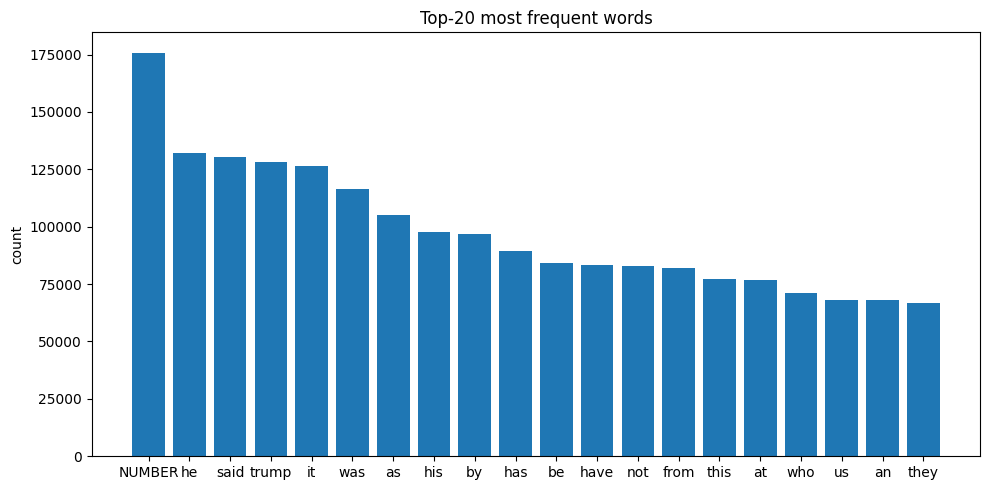

In [89]:

from collections import Counter
from itertools import chain

tokens = chain.from_iterable(df["full_text"].str.split())

word_counts = Counter(tokens).most_common(20)

freq_df = pd.DataFrame(word_counts, columns=["word", "frequency"])

plt.figure(figsize=(10,5))
plt.bar(freq_df["word"], freq_df["frequency"])
plt.title(f"Top-20 most frequent words")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [90]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)
df.head()

,date,text_length,label,full_text
0,"January 7, 2017",387,0,emotional farewell speech michelle obama prais...
1,"November 1, 2017",96,0,resigning uk defence minister fallon says cond...
2,"September 8, 2017",269,0,state department approves NUMBER billion arms ...
3,"Jun 4, 2017",306,1,proactive president trump just took huge step ...
4,"October 12, 2016",932,0,putin rejects accusations meddling us election...


#MODEL TRAINING

In [91]:
from sklearn.model_selection import train_test_split


X = df[['full_text']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

In [93]:

preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(
        max_features=1000,  
        min_df=5,     
        ngram_range=(1, 1),       
        stop_words='english'
    ), 'full_text')
])

In [94]:
from sklearn.model_selection import cross_val_score
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(
    max_depth=5,             
    min_samples_leaf=50,       
    random_state=42
),
    'Random Forest': RandomForestClassifier(
    n_estimators=150,        
    max_depth=5,            
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1                
),
    'Gradient Boosting': GradientBoostingClassifier(    n_estimators=150,
    learning_rate=0.05,        
    max_depth=3,
    random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('features', preprocessor),
        ('classifier', model)
    ])
    cv_scores = cross_val_score(
        pipeline,               
        X_train, y_train,    
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    print(f"[{name}] CV-F1 = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print()

[Logistic Regression] CV-F1 = 0.987 ± 0.000
=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4223
           1       0.99      0.99      0.99      4757

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


[Decision Tree] CV-F1 = 0.994 ± 0.001
=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4223
           1       1.00      0.99      0.99      4757

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


[Random Forest] CV-F1 = 0.989 ± 0.002
=== Random Forest ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4223
           1       1.00      0.98      0.99

I decided to use Logistic Reggresion 

In [95]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold


pipe = Pipeline([
    ('features', preprocessor),          
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


param_grid = {
    # ----- TF-IDF -----
    'features__tfidf__max_features': [500, 1000, 2000],
    'features__tfidf__ngram_range':  [(1, 1), (1, 2)],

    # ----- LogisticRegression -----
    'classifier__penalty': ['l2', 'l1'],        
    'classifier__solver':  ['liblinear'],
    'classifier__C':       [0.1, 1.0, 10.0],
    'classifier__class_weight': [None, 'balanced']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator  = pipe,
    param_grid = param_grid,
    cv         = cv,
    scoring    = 'f1_macro',
    n_jobs     = -1,
    verbose    = 2
)


grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best score CV:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'classifier__C': 10.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'features__tfidf__max_features': 2000, 'features__tfidf__ngram_range': (1, 2)}
Best score CV: 0.9960952862979843
              precision    recall  f1-score   support

           0      0.995     0.996     0.996      4223
           1      0.997     0.995     0.996      4757

    accuracy                          0.996      8980
   macro avg      0.996     0.996     0.996      8980
weighted avg      0.996     0.996     0.996      8980



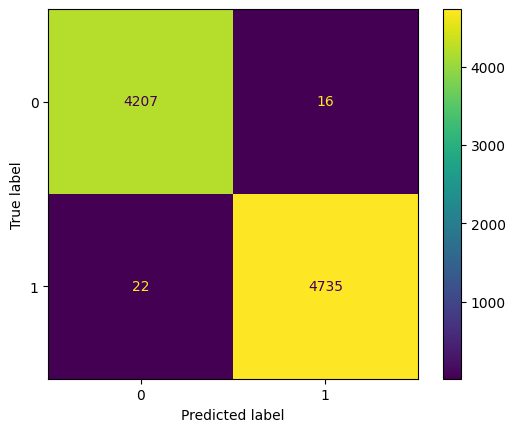

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)



disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()